# 基于时序数据的多维特征因果关系建模方法研究

###   by BTBU 聂春雪

### 说明：

1.代码使用anaconda python2.7 jupyter notebook 编程

2.python3使用中注意中英文名称的变化，/除法python2为取整

3.程序逻辑：先读取数据，处理后保存成多维特征excel表（矩阵），之后再建立不同模型

4.数据读取中使用的是wind收费数据库，需要有wind账号登录，同时可换成其他如通联数据（优矿），聚宽等免费平台提供的数据。

5.与多因子策略不同为：该策略为时间序列策略，多因子为横截面（所有股票同一时间选股）策略

6.模型说明，指标计算方法如论文所述

In [2]:
# 导入库
%matplotlib inline
import pandas as pd
import numpy as np
import pdb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
# 导入wind接口，获取数据,须有wind账号
# from WindPy import *
# w.start()

# 一、特征数据的计算

In [ ]:
#wind读取数据保存到本地,excel读取原始数据保存到szfactor.xlsx
data = w.wsd("000001.SH", "turn", "2000-01-01", "2017-03-31", "")
df = pd.DataFrame(np.array(data.Data).T,index = [x.strftime("%Y-%m-%d") for x in data.Times],columns=data.Codes)
df.to_excel('F:\\DataBase\\turn.xlsx',sheet_name='turn')

In [219]:
# 特征预处理
# 标准化，也可以使用市值加权，参考长江证券
def normalize(inputData):
    return inputData.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [ ]:
# 从本地导入文件，2010年1月1日-2017.3.31
factor = pd.read_excel(u'F:\多维特征\实验结果\szfactor.xlsx',index_col='Date')#,'Sheet1',index_col=None,na_values=['NA']).values
#factor = [allstocks[i,0] for i in range(0,len(allstocks))]
# 标准化
normfactor = normalize(factor)
plt.plot(normfactor['close'].values)#标准化后与原数据走势一致

In [154]:
# kalman算法
# -*- coding: utf-8 -*-
# -*- encoding: utf-8 -*-
from numpy import *
from math import *
def mykalmanadfun(A,U,C,Q,R,xe,y,p,Ea):
    #This function is to calculate the estimation state and the real state.
    xee=A*xe+U*Ea
    p=A*p*A.T+Q
    l=p*(C.T)*((C*p*(C.T)+R).I)
    xe=xee+l*(y-C*xe)
    pk=(eye(len(p))-l*C)*p
    return xe,xee,pk

def myStarmodel(T,a,qq):
    A=mat([[1,T,(a*T-1+exp(-a*T))/a/a],[0,1,(1-exp(-a*T))/a],[0,0,exp(-a*T)]])   
    q11=(1-exp(-2*a*T)+2*a*T+2*(a**3)*(T**3)/3-2*a**2*T**2-4*a*T*exp(-a*T))/2/(a**5)
    q12=(exp(-2*a*T)+1-2*exp(-a*T)+2*a*T*exp(-a*T)-2*a*T+a**2*T**2)/2/(a**4)
    q13=(1-exp(-2*a*T)-2*a*T*exp(-a*T))/2/(a**3)
    q22=(4*exp(-a*T)-3-exp(-2*a*T)+2*a*T)/2/(a**3)
    q23=(exp(-2*a*T)+1-2*exp(-a*T))/2/(a**2)
    q33=(1-exp(-2*a*T))/2/a
    Q=qq*mat([[q11,q12,q13],[q12,q22,q23],[q13,q23,q33]])
    U=mat([[(-T+T**2/2+(1-exp(-a*T))/a)/a],[T-(1-exp(-a*T))/a],[1-exp(-a*T)]])
    return A,Q,U

def funDataDrivenModelYW(C,TT,R,a,qq,xe,p,y):
    xx1=[];aa1=[];qq1=[];Ea1=[];RR0=[];RR1=[];P33=[];NN=[];
    xxe1=[];
    Ea=xe[2]
    MM=3
    for i in range(1,size(y)+1):
        T=TT
        if i==1:
            [A,Q,U]=myStarmodel(T,a,qq)
            [xe,xee,p]=mykalmanadfun(A,U,C,Q,R,xe,y[0,i-1],p,Ea)
            Ea=xe[2]
            R0=xe[2]*xe[2]
            R1=xe[2]
        else:
            if i>4:
                b=R1/R0
#                 print b
                if b>0:
                    qb=(R0-b*R1)
                    a=-log(b)/T
                    qq=2*a*qb/(1-b*b)
                    #print qq
                    qq=qq[0,0]
                    #print qq
                    if qq>1000:
                        qq=1000
            [A,Q,U]=myStarmodel(T,a,qq)
            [xe,xee,p]=mykalmanadfun(A,U,C,Q,R,xe,y[0,i-1],p,Ea)
            Ea=mean(xe[2]+ mat(xx1[i-2][2]))
            R0=R0+((xe[2])*(xe[2])-R0)/i
            R1=R1+((xe[2])*(xx1[i-2][2])-R1)/i
        xx1.append(xe)
        xxe1.append(xee)
        Ea1.append(Ea)
        P33.append(p[2,2])
    xxe1=mat(array (xxe1)).T
    return xx1,xxe1

def cal_vasignal(data_withHist):
    s = mat(data_withHist)
    #测量方差的设置
    R= 100
    #选择模型参数
    a=1.0/20
    xamax=5.0
    qq=(xamax)**2*(4-pi)/pi
    C=mat([1,0,0])
    xe=zeros((3,1))
    p=100000*eye(3)
    TT=0.2
    xx1,xxe1=funDataDrivenModelYW(C,TT,R,a,qq,xe,p,s)
    '''
    FeactureData=array(mat([0,1,0])*xxe1-mat([0,0,1])*xxe1)[0]
    if FeactureData[-1]-FeactureData[-2]>g.thresholdup:
        signal=1 
    elif FeactureData[-1]-FeactureData[-2]<g.thresholddown:
        signal=-1
    return signal
    '''
    #print xxe1
    s = array(mat([1,0,0])*xxe1)
    v = array(mat([0,1,0])*xxe1)
    a = array(mat([0,0,1])*xxe1)
    #print FeactureData[-1]-FeactureData[-2]
    # signal=0
    # if v[0][-1]>0 and a[0][-1]>0:
    #     signal=1 
    # elif v[0][-1]<0 and a[0][-1]>0:
    #     signal=-1
    #return signal
    return s[-1],v[-1],a[-1]

In [ ]:
#计算动力学特征
interval = 150
V = {}
A={}
S={}
allday = [day.strftime("%Y-%m-%d") for day in list(normfactor.index)]
price  = normfactor['close'].values
for i in range(0,len(price)-interval-1):
    print (i)
    x = price[i:i+interval]
    s,v,a = cal_vasignal(x)
    V[allday[i+interval+1]] = v[-1]
    A[allday[i+interval+1]] = a[-1]
    S[allday[i+interval+1]] = s[-1]
normfactor1=normfactor[interval+1:]
normfactor1['v']=V.values()
normfactor1['a']=A.values()
normfactor1['s']=S.values()

In [112]:
# 特征数据保存到本地，便于以后直接调用
pd.DataFrame(normfactor1).to_excel('F:\\多维特征\\实验结果\\normfactor3_150.xlsx',sheet_name='normfactor1')

# 二、建模过程

In [6]:
#本地读入中间保存的特征数据表
factorData = pd.read_excel(u'F:\\多维特征\\实验结果\\normfactor3_150.xlsx',index_col='Date')
factorData = factorData[1:]
factorData

close    volume        MA    pe_ttm   pct_chg      Turn  \
Date                                                                     
2000-08-24 -0.327122 -0.713831 -0.311792  2.240181 -0.519331  1.911543   
2000-08-25 -0.310181 -0.744962 -0.316250  2.265095  0.375733  1.010587   
2000-08-28 -0.295050 -0.736264 -0.317009  2.371270  0.441631  0.469904   
2000-08-29 -0.289718 -0.746707 -0.318778  2.293748  0.389164  0.695711   
2000-08-30 -0.321692 -0.746671 -0.312062  2.289167  0.122687  0.496326   
2000-08-31 -0.381582 -0.736193 -0.308085  2.232505 -0.879338  0.539816   
2000-09-01 -0.404843 -0.753120 -0.318988  2.129530 -1.651659  0.681547   
2000-09-04 -0.393133 -0.767987 -0.337940  2.175069 -0.671437  0.332713   
2000-09-05 -0.444157 -0.772060 -0.357576  2.110348  0.310240  0.079759   
2000-09-06 -0.485453 -0.771827 -0.388495  2.020446 -1.455516 -0.012670   
2000-09-07 -0.458468 -0.780307 -0.421279  1.947597 -1.209645  0.015477   
2000-09-08 -0.449040 -0.784934 -0.436672  1.993452  0.771335 -0.173921   
2000-09-11 -0.435163 -0.781073 -0.445520  2.092836  0.252436 -0.266441   
2000-09-12 -0.427476 -0.787522 -0.453935  2.034893  0.379618 -0.175102   
2000-09-13 -0.416750 -0.782215 -0.450595  2.048418  0.199569 -0.299763   
2000-09-14 -0.427030 -0.790463 -0.436841  2.068108  0.285627 -0.160847   
2000-09-15 -0.428197 -0.793693 -0.430547  2.049965 -0.313006 -0.340076   
2000-09-18 -0.462730 -0.789818 -0.426374  2.135151 -0.054141 -0.399546   
2000-09-19 -0.510254 -0.775937 -0.431893  1.992257 -1.007603 -0.340530   
2000-09-20 -0.489396 -0.790447 -0.448465  1.903964 -1.400927 -0.085941   
2000-09-21 -0.505728 -0.792408 -0.463009  1.939680  0.598796 -0.341619   
2000-09-22 -0.522429 -0.789790 -0.478764  1.912364 -0.501123 -0.373942   
2000-09-25 -0.539949 -0.802334 -0.497630  1.967764 -0.515849 -0.367586   
2000-09-26 -0.526958 -0.805142 -0.513089  1.856030 -0.544319 -0.580228   
2000-09-27 -0.498338 -0.805755 -0.516433  1.878957  0.370712 -0.632616   
2000-09-28 -0.525367 -0.801869 -0.518223  1.929231  0.836309 -0.646599   
2000-09-29 -0.502616 -0.802511 -0.522155  1.881272 -0.819145 -0.564248   
2000-10-09 -0.496960 -0.789909 -0.518188  2.004810  0.660000 -0.573327   
2000-10-10 -0.467748 -0.776512 -0.509582  1.935087  0.146605 -0.479536   
2000-10-11 -0.476930 -0.771410 -0.497728  1.987491  0.841432 -0.318194   
...              ...       ...       ...       ...       ...       ...   
2017-02-20  0.946896  1.222914  0.922555 -0.670869 -0.546345 -0.496243   
2017-02-21  0.961464  1.041314  0.927601 -0.658359  0.708318 -0.479990   
2017-02-22  0.970067  1.003898  0.935326 -0.654608  0.233393 -0.542639   
2017-02-23  0.959337  1.019204  0.945851 -0.652603  0.128704 -0.555441   
2017-02-24  0.961580  0.817258  0.950599 -0.655413 -0.206802 -0.549358   
2017-02-27  0.934578  0.783336  0.961806 -0.655518  0.018201 -0.619996   
2017-02-28  0.948827  0.505453  0.959340 -0.662110 -0.490025 -0.632616   
2017-03-01  0.954496  0.855133  0.956810 -0.659059  0.228719 -0.728496   
2017-03-02  0.936069  0.771223  0.953693 -0.657697  0.078059 -0.607012   
2017-03-03  0.923298  0.557223  0.949034 -0.662426 -0.341652 -0.635976   
2017-03-06  0.940252  0.548442  0.941370 -0.666326 -0.244330 -0.710427   
2017-03-07  0.949561  0.619136  0.942506 -0.662197  0.277028 -0.713605   
2017-03-08  0.947663  0.589581  0.942653 -0.659090  0.141950 -0.689091   
2017-03-09  0.921590  0.648460  0.941285 -0.661925 -0.053902 -0.699441   
2017-03-10  0.917246  0.376238  0.938387 -0.668926 -0.475641 -0.678922   
2017-03-13  0.943695  0.615673  0.937175 -0.670888 -0.097153 -0.773530   
2017-03-14  0.946205  0.467338  0.937864 -0.663225  0.444618 -0.690816   
2017-03-15  0.948856  0.441707  0.937193 -0.662271  0.023051 -0.742932   
2017-03-16  0.978478  0.843946  0.937432 -0.661918  0.025465 -0.751648   
2017-03-17  0.944155  0.942973  0.948821 -0.655209  0.495799 -0.611915   
2017-03-20  0.958719  0.676635  0.954208 -0.665211 -0.614403 -0.577595   
2017-03-21  0.97049

count    4022.000000
mean       -0.040671
std         0.980626
min        -1.007780
25%        -0.683189
50%        -0.392464
75%         0.271677
max         6.346322
Name: Turn, dtype: float64
('skew', 2.226224273591745)
('kurt', 6.1967348976273691)


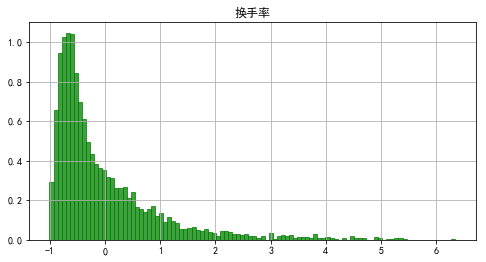

In [12]:
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

# 特征统计结果可视化
x=factorData['Turn']
df_allday=pd.Series(x[~np.isnan(x)])
print (df_allday.describe())
print ('skew',df_allday.skew())#偏度
print ('kurt',df_allday.kurt())#峰度
plt.figure(figsize=(8,4))
plt.title(u'换手率') 
plt.hist(df_allday.values,100,normed=1,facecolor='g',edgecolor='g',alpha=0.75)
#plt.xlim(-2,2)
plt.grid(True)

F:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
F:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
F:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
F:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70

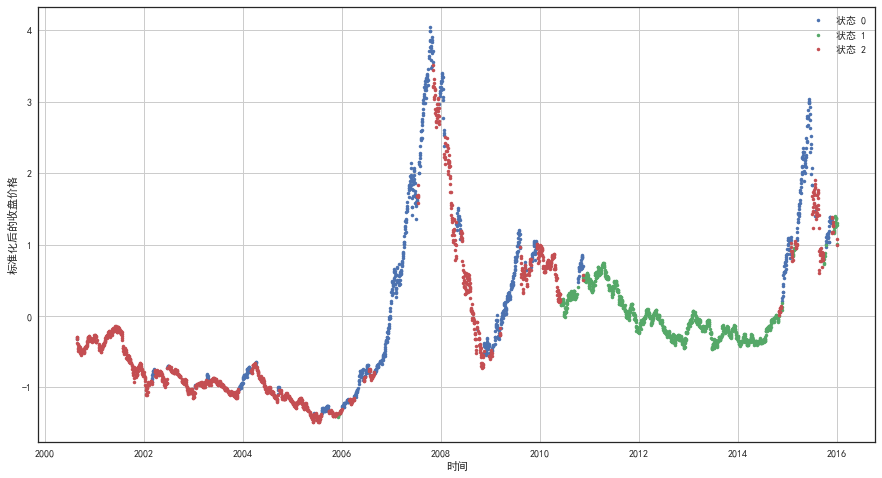

In [14]:
#隐马尔可夫建模
from hmmlearn.hmm import GMMHMM,GaussianHMM
import seaborn as sns
XX=factorData.ix[:,[7,13,5,4,3]].values
hmm = GaussianHMM(n_components = 3, covariance_type='diag',n_iter = 5000).fit(XX[:-300])
latent_states_sequence = hmm.predict(XX[:-300])
#len(latent_states_sequence)
sns.set_style('white')
plt.figure(figsize = (15, 8))
close =factorData['close'][:-300]
#各状态散点图
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    #pdb.set_trace()
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

    plt.plot(close[state].index,close[state].values,'.',label = u'状态 %d'%i,lw = 1)
    plt.ylabel(u'标准化后的收盘价格')
    plt.xlabel(u'时间')
    plt.legend()
    plt.grid(1)

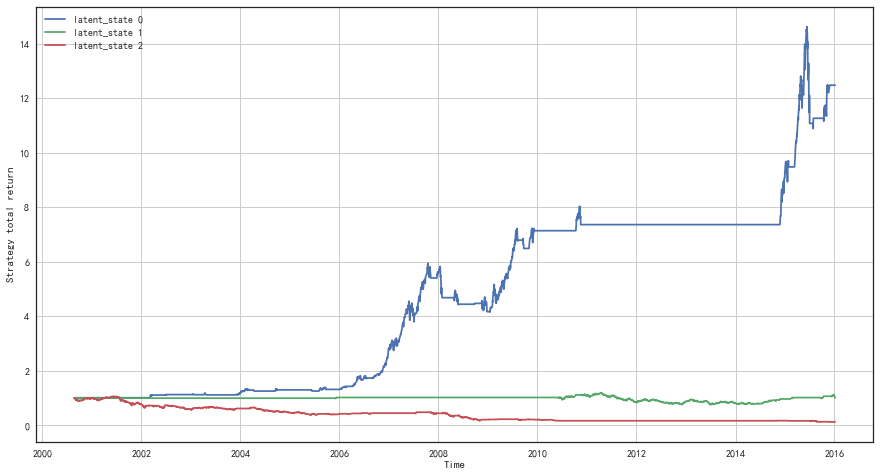

In [16]:
#各状态对应的净值曲线
close = pd.read_excel(u'F:\\多维特征\\实验结果\\close.xlsx',index_col='Date')[151:-300]
datelist = pd.to_datetime(close.index[1:])
logreturn = (np.log(np.array(close[1:]))-np.log(np.array(close[:-1])))
data = pd.DataFrame({'datelist':datelist,'logreturn':logreturn.T[0],'state':latent_states_sequence}).set_index('datelist')
plt.figure(figsize=(15,8))
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    idx = np.append(0,state[:-1])
    data['state %d_return'%i] = data.logreturn.multiply(idx,axis = 0) 
    plt.plot(np.exp(data['state %d_return' %i].cumsum()),label = 'latent_state %d'%i)
    plt.ylabel('Strategy total return')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(1)

In [18]:
#交易点确定
buysell=[]
s='sell'
for x in latent_states_sequence:
    # 注意与上图中颜色相一致
    if x==0 and s=='sell':
        s='buy'
        buysell.append(1)
    elif x!=0 and s=='buy':
        s='sell'
        buysell.append(-1)
    else:
        buysell.append('')
close = pd.read_excel(u'F:\\多维特征\\实验结果\\close.xlsx',index_col='Date')#,'Sheet1',index_col=None,na_values=['NA']).values
df = close.ix['2000-08-24':'2016-01-06']##2000-09-20
df['states']=latent_states_sequence
df['buysell']=buysell

F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


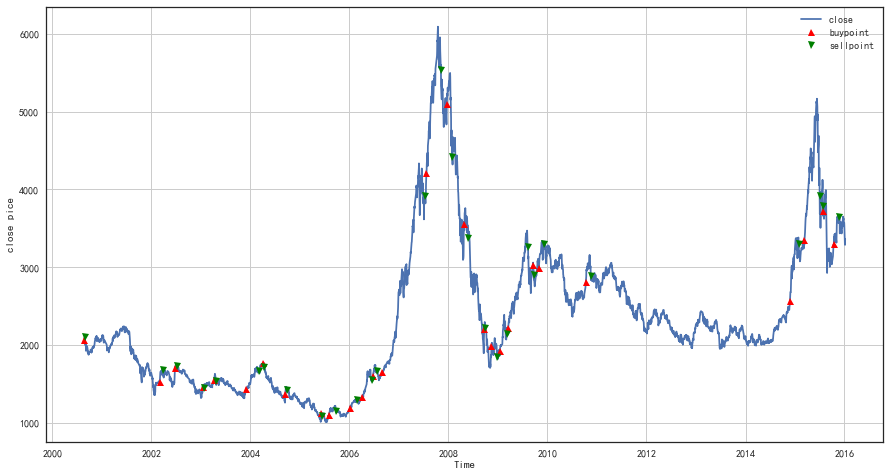

In [19]:
#画出买卖点图
df['buysell']=buysell#[:-300]
plt.figure(figsize=(15,8))
plt.plot(df.index,df['close'])
plt.plot(df.index[df['buysell']==1],df['close'][df['buysell']==1],'r^',label='buypoint')
plt.plot(df.index[df['buysell']==-1],df['close'][df['buysell']==-1],'gv',label='sellpoint')
#plt.plot(df.index[df['buysell']==0],df['close'][df['buysell']==0],'gv')
plt.ylabel('close pice')
plt.xlabel('Time')
plt.legend()
plt.grid(1)
#ax.plot(df.index[df['buysell']!=''],df['close'][df['buysell']!=''],'-',label='buysell')

In [8]:
#保存状态序列
np.savetxt('latent_states_sequence.txt',latent_states_sequence)

In [21]:
#计算总交易次数及胜率
trade = df['close'][df['buysell']!=''].pct_change()
winrate = len([x for x in trade if x>0])/float(len(trade))
print(len(trade))
print(winrate)

56
0.571428571429


In [22]:
#计算策略每日净资产
Nav = []
Num = [0]
# 初始资金
initfund = 1000000
# 现金
Money = [initfund]
n=0
for i in range(len(df)):
    price = df['close'][i]
    buysellpoint = df['buysell'][i]
    #buysellpoint = factorData['class'][i]
    if buysellpoint == 1 and n==0:
        n=n+1
        num = int(initfund/price)
        money = initfund-price*num
        Num.append(num)
        Money.append(money)
    elif buysellpoint == -1 and n!=0:
        money = Money[-1]+price*Num[-1]
        Num.append(0)
        Money.append(money) 
    elif buysellpoint == 1 and n!=0:
        num = int(Nav[-1]/price)
        money = Nav[-1]-price*num
        Num.append(num)
        Money.append(money)
    elif buysellpoint == 0:
        Num.append(Num[-1])
        Money.append(Money[-1])
    Nav.append(Num[-1]*price+Money[-1])

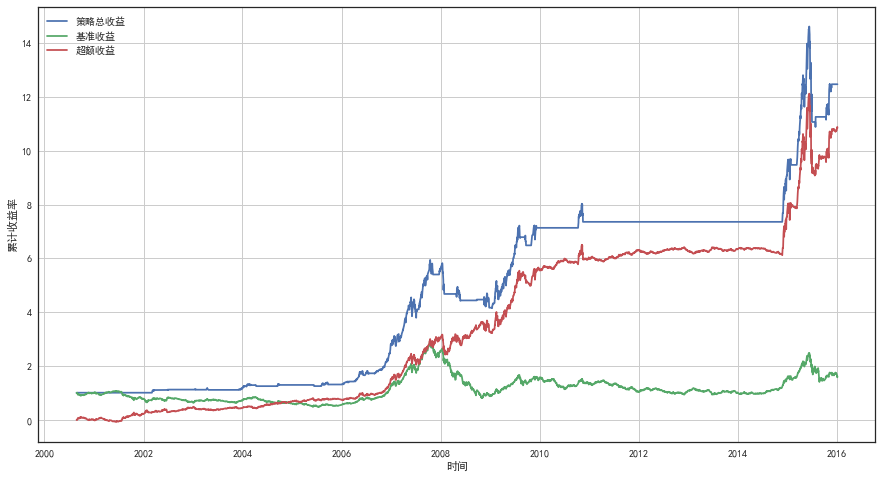

In [26]:
#收益率曲线
initfund = 1000000
num = int(initfund/(df['close'][0]))
indexnav = df['close']*num+initfund-df['close'][0]*num
indexshouyi = (1+indexnav.pct_change()).cumprod()                    

shouyi = (1+pd.DataFrame(Nav).pct_change()).cumprod() 
plt.figure(figsize=(15,8))
plt.plot(indexshouyi.index,shouyi,label=u'策略总收益')
plt.plot(indexshouyi,label=u'基准收益')
plt.plot(indexshouyi.index,shouyi.values.T[0]-indexshouyi.values,label=u'超额收益')
plt.ylabel(u'累计收益率')
plt.xlabel(u'时间')
plt.legend()
plt.grid(1)

In [55]:
#策略累计收益
print (shouyi.values[-1])
print (indexshouyi.values[-1])

[ 10.47324098]
1.622107278


In [31]:
#超额年化收益
n = len(shouyi)#策略执行天数
a= shouyi.values.T[0]-indexshouyi.values
TotalAnnualizedReturns = ((1+a[-1])**(250.0/n)-1)
TotalAnnualizedReturns

0.18063064580247468

In [32]:
# 年化收益率
TotalReturns = (shouyi.values[-1]-shouyi.values[1])/shouyi.values[1]
n = len(shouyi)#策略执行天数
TotalAnnualizedReturns = ((1+TotalReturns)**(250.0/n)-1)
TotalAnnualizedReturns

array([ 0.18410223])

In [33]:
# 夏普比率
#策略波动率
AlgorithmVolatility = pd.DataFrame(Nav).pct_change().std().values*np.sqrt(250)
Sharpe = (TotalAnnualizedReturns-0.04)/AlgorithmVolatility
Sharpe

array([ 0.92904459])

In [34]:
# 年化基准收益
TotalReturns = (indexshouyi.values[-1]-indexshouyi.values[1])/indexshouyi.values[1]
n = len(indexshouyi)#策略执行天数
TotalAnnualizedReturns = ((1+TotalReturns)**(250.0/n)-1)
TotalAnnualizedReturns

0.032506878422925656

-0.301725108195


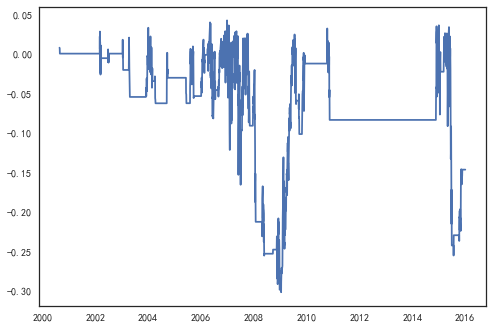

In [35]:
#回撤
maxdrawdown=[]
for i in range(1,len(Nav)):
    C = max(np.array(Nav[:i]))
    if C==Nav[i]:
        maxdrawdown.append(0)
    else:
        maxdrawdown.append((Nav[i]-C)/C)
print (np.min(maxdrawdown))
plt.plot(indexshouyi.index[1:],maxdrawdown)

In [36]:
# 贝塔值
x = pd.DataFrame(indexnav).pct_change()['close'][1:].values
y = pd.Series(Nav).pct_change()[1:].values
X = np.vstack((x,y))
pctcov = np.cov(X)[0,1]
pctvar = pd.DataFrame(indexnav).pct_change().var().values
Beta = pctcov/pctvar
Beta

array([ 0.35544679])

F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()


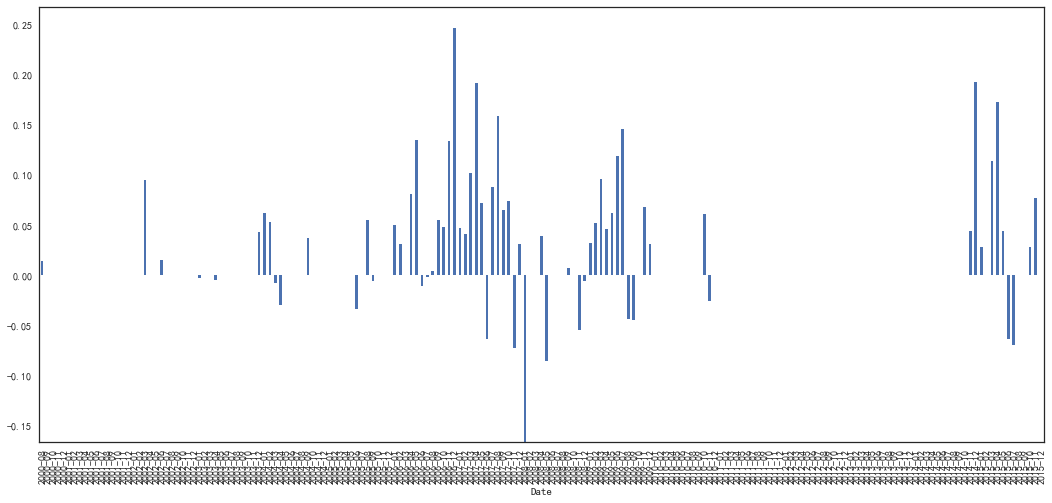

In [37]:
#月收益率
df['Nav']=Nav
monReturn = df['Nav'].pct_change().resample('M',how='sum',kind='period')
(monReturn[:-1]).plot(kind='bar', stacked=True,figsize=(18,8))

F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()


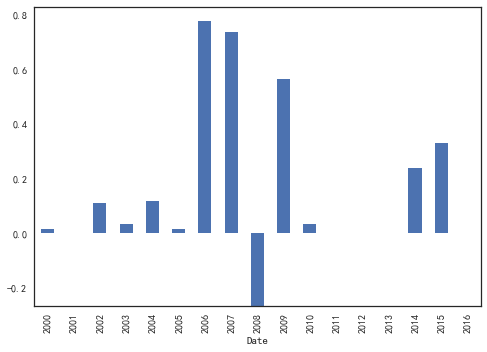

In [38]:
#年收益率
df['Nav']=Nav
yearReturn = df['Nav'].pct_change().resample('A',how='sum',kind='period')
(yearReturn).plot(kind='bar', stacked=True)

# 三、不同模型建模

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn import tree
clf1 = tree.DecisionTreeClassifier()
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = svm.SVC(decision_function_shape='ovo')
clf5 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
clf6 = AdaBoostClassifier(n_estimators=100)
# 不同模型准确率
X=factorData.ix[:,[7,13,5,4,3]].values
Y=factorData['class'].values
# 切割样本集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
eclf = VotingClassifier(estimators=[('rf', clf2), ('gnb', clf3),('lr4', clf4), ('rf5', clf5), ('gnb6', clf6)], voting='hard')
results={}
for clf, label in zip([clf1,clf2, clf3, clf4,clf5,clf6,eclf], ['DT','Random Forest', 'naive Bayes', 'SVC','GradientBoosting','adaboost','ensemble']):
    #print (label)
    clf = clf.fit(X_train, y_train)
    #results[label]=clf.predict(X_test, y_test)
    # 样本内检验
    scores = clf.score(X_train, y_train) 
    print("Accuracy: %0.2f [%s]" % (scores, label))

Accuracy: 1.00 [DT]
Accuracy: 0.99 [Random Forest]
Accuracy: 0.83 [naive Bayes]
Accuracy: 0.81 [SVC]
Accuracy: 0.90 [GradientBoosting]
Accuracy: 0.88 [adaboost]
Accuracy: 0.91 [ensemble]


In [40]:
#class在excel中计算
buysell=factorData['class'].values
buysell

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn import tree
clf1 = tree.DecisionTreeClassifier()
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = svm.SVC(decision_function_shape='ovo')
clf5 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
clf6 = AdaBoostClassifier(n_estimators=100)
# 手动切割,样本外实验结果
X=factorData.ix[:,[7,13,5,4,3]].values
Y=factorData['class'].values
X_train=X[:-300]
X_test=X[-300:]
y_train=Y[:-300]
y_test=Y[-300:]
for clf, label in zip([clf1,clf2, clf3, clf4,clf5,clf6,eclf], ['DT','Random Forest', 'naive Bayes', 'SVC','GradientBoosting','adaboost','ensemble']):
    #print (label)
    clf = clf.fit(X_train, y_train)
    #results[label]=clf.predict(X_test)
    scores = clf.score(X_test, y_test) 
    print("Accuracy: %0.2f [%s]" % (scores, label))

# close = pd.read_excel('F:\\多维特征\\实验结果\\close.xlsx',index_col='Date')#,'Sheet1',index_col=None,na_values=['NA']).values
# df = close.ix['2000-09-20':'2016-01-06']##2000-09-20
# df['states']=latent_states_sequence
# df['buysell']=buysell

Accuracy: 0.76 [DT]
Accuracy: 0.81 [Random Forest]
Accuracy: 0.74 [naive Bayes]
Accuracy: 0.75 [SVC]
Accuracy: 0.82 [GradientBoosting]
Accuracy: 0.79 [adaboost]
Accuracy: 0.82 [ensemble]


# 四、其他非线性模型策略回测结果

In [42]:
#adaboost
clf = clf6.fit(X_train, y_train)
#clf.predict(X_train)
buysell=[]
s='sell'
for x in clf.predict(X_test):#y_train:#
    if x==1 and s=='sell':
        s='buy'
        buysell.append(1)
    elif x!=1 and s=='buy':
        s='sell'
        buysell.append(-1)
    else:
        buysell.append('')
#buysell

In [45]:
close = pd.read_excel(u'F:\\多维特征\\实验结果\\close.xlsx',index_col='Date')#,'Sheet1',index_col=None,na_values=['NA']).values
df = close.ix['2016-01-07':]##2000-09-20
df['buysell']=buysell
trade = df['close'][df['buysell']!=''].pct_change()
winrate = len([x for x in trade if x>0])/float(len(trade))
print(len(trade))
print(winrate)

42
0.547619047619


F:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [46]:
Nav = []
Num = [0]
initfund = 1000000
Money = [initfund]
n=0
for i in range(len(df)):
    price = df['close'][i]
    buysellpoint = df['buysell'][i]
    #buysellpoint = factorData['class'][i]
    if buysellpoint == 1 and n==0:
        n=n+1
        num = int(initfund/price)
        money = initfund-price*num
        Num.append(num)
        Money.append(money)
    elif buysellpoint == -1 and n!=0:
        money = Money[-1]+price*Num[-1]
        Num.append(0)
        Money.append(money) 
    elif buysellpoint == 1 and n!=0:
        num = int(Nav[-1]/price)
        money = Nav[-1]-price*num
        Num.append(num)
        Money.append(money)
    elif buysellpoint == 0:
        Num.append(Num[-1])
        Money.append(Money[-1])
    Nav.append(Num[-1]*price+Money[-1])

In [50]:
#收益率曲线
#_, ax = plt.subplots(figsize = [18,8])

initfund = 1000000
num = int(initfund/(df['close'][0]))
indexnav = df['close']*num+initfund-df['close'][0]*num
indexshouyi = (1+indexnav.pct_change()).cumprod()                    
#plt.plot(indexshouyi)
shouyi = (1+pd.DataFrame(Nav).pct_change()).cumprod()        
#plt.plot(shouyi)
# 年化收益率
TotalReturns = (shouyi.values[-1]-shouyi.values[1])/shouyi.values[1]
n = len(shouyi)#策略执行天数
TotalAnnualizedReturns = ((1+TotalReturns)**(250.0/n)-1)
print u'年化收益率',TotalAnnualizedReturns

# 年化基准收益
TotalReturns = (indexshouyi.values[-1]-indexshouyi.values[1])/indexshouyi.values[1]
n = len(indexshouyi)#策略执行天数
TotalAnnualizedReturns = ((1+TotalReturns)**(250.0/n)-1)
print u'年化基准收益率',TotalAnnualizedReturns

#回撤
maxdrawdown=[]
for i in range(1,len(Nav)):
    C = max(np.array(Nav[:i]))
    if C==Nav[i]:
        maxdrawdown.append(0)
    else:
        maxdrawdown.append((Nav[i]-C)/C)
#plt.plot(maxdrawdown)
print u'回撤',np.min(maxdrawdown)

# 夏普比率
#策略波动率
AlgorithmVolatility = pd.DataFrame(Nav).pct_change().std().values*np.sqrt(250)
Sharpe = (TotalAnnualizedReturns-0.04)/AlgorithmVolatility
print u'夏普',Sharpe

年化收益率 [-0.01686382]
年化基准收益率 0.00940395255374
回撤 -0.0919072409006
夏普 [-0.33322223]
